# Example notebook

Let's assume you run the regression for the Gaussian Process Emulator using `Snakemake`, so you have set `model = "gp"` in `Snakefile` and then execute:

```
snakemake regression --cores=1
```

Now, you should be able to load the model from file using `pickle` and run your own scenarios. This is an example how you could do it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
fnm = "../data/interim/runs_2300-1yr.pkl"
with open(fnm, "rb") as f:
    data = pickle.load(f)

[2.4, 0.6, 0.75, 5.0]
(285, 7)


Text(0, 0.5, 'SLR [m]')

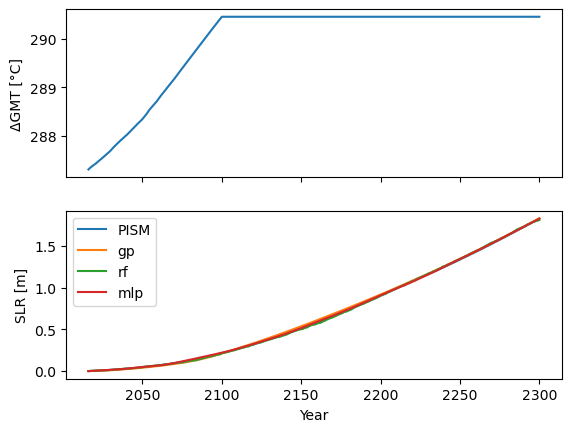

In [3]:
fig, ax = plt.subplots(2,1, sharex=True)

scen = "rcp85"

expid = 42
if scen == "rcp85":
    expid += 81


y = data[1][expid]["sea_level_rise_potential"].values
t2 = data[1].index.values
y = y[0] - y
# print(y)

pism_start = t2[0]
# pism_start = 1990 # try starting at any other time
temperature = data[2].loc[pism_start:][scen]["global_mean_temperature"].values
t = data[2].loc[pism_start:].index.values
N = len(t)

ax[0].plot(t,temperature)
ax[0].set_ylabel("ΔGMT [°C]")

# create forcing for SLR emulator
p = list(data[0].loc[expid][1:].values)
print(p)

temperature_cumsum = np.cumsum(temperature)
T_last_change_since = np.cumsum(temperature - np.roll(temperature,1)==0)
X = []
for i in range(N):
    this_X = p+[temperature[i],temperature_cumsum[i],T_last_change_since[i]]
    X.append(this_X)
print(np.array(X).shape)
# and make prediction

ax[1].plot(t2,y,label="PISM")
for m in ["gp","rf","mlp"]:
    fnm = f"../models/{m}.pkl"
    with open(fnm, "rb") as f:
        model = pickle.load(f)
    
    y_pred = model.predict(X)
    y_pred -= y_pred[list(t).index(t2[0])] # center sea level at PISM's start date
    ax[1].plot(t,y_pred.flatten(),label=m)
ax[1].legend()
ax[1].set_xlabel("Year")
ax[1].set_ylabel("SLR [m]")